In [1]:
!pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
#бибилиотеки для работы с графикой
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
!python -V

Python 3.7.0


In [283]:
#df= pd.read_csv("mainDataset-cool-next.csv", skipinitialspace=True, sep=";")
df= pd.read_csv(r"C:\Users\KK\Downloads\main_dataset8_thr12.csv", skipinitialspace=True, sep=",")
#df= pd.read_csv("mainDataset-all-without.csv", skipinitialspace=True, sep=";")
#df= pd.read_csv("scopus.csv", skipinitialspace=True, sep=",")

In [284]:
target_names = list(df['CurElementMark'].unique())

In [285]:
target_names

['b0',
 'c1',
 'a3',
 'a2',
 'a1',
 'bb',
 'm0',
 'c2',
 'g0',
 'd2',
 'd3',
 'b1',
 'b2',
 'd4',
 'd5',
 'r0',
 'f0',
 'h0',
 'b3',
 'i2',
 'i0',
 'd0']

## Количество элементов по признакам

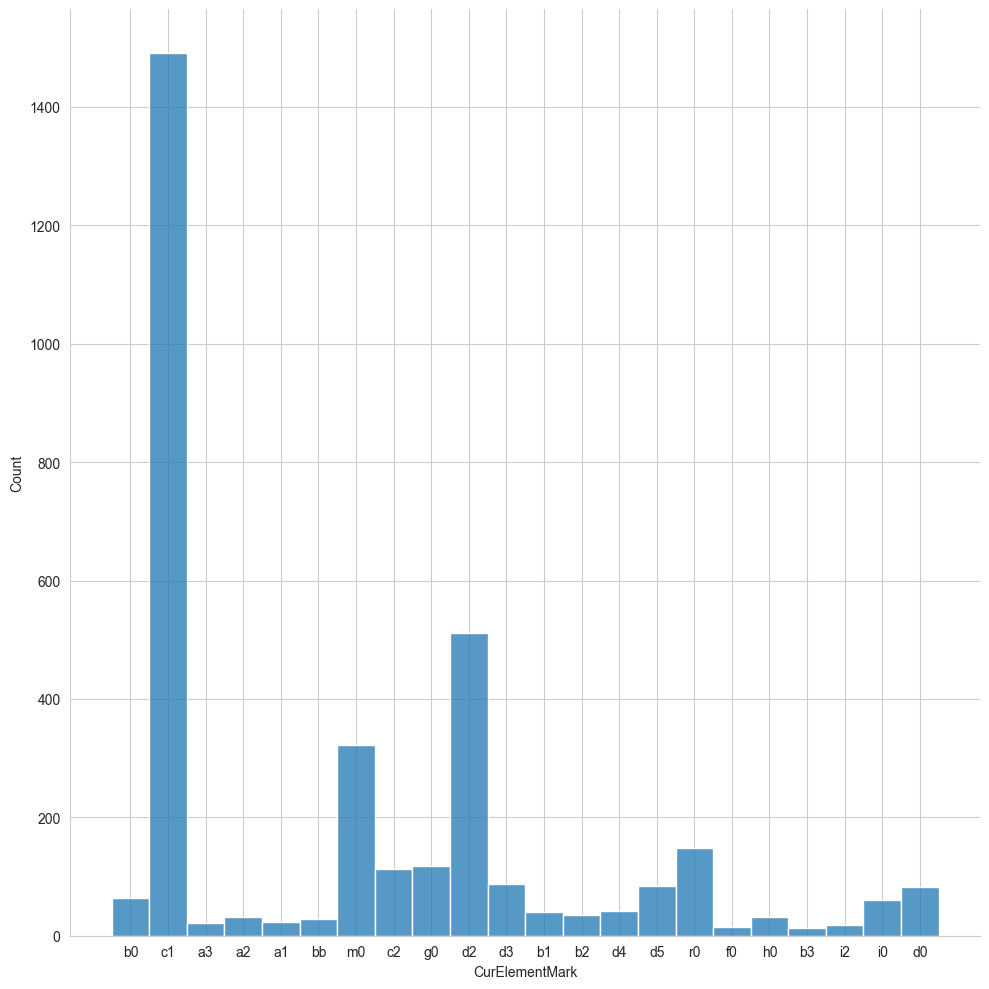

In [286]:
sns.displot(df['CurElementMark'], height=10)
#sns.countplot(df['CurElementMark'])

## Пустые значения

<AxesSubplot:>

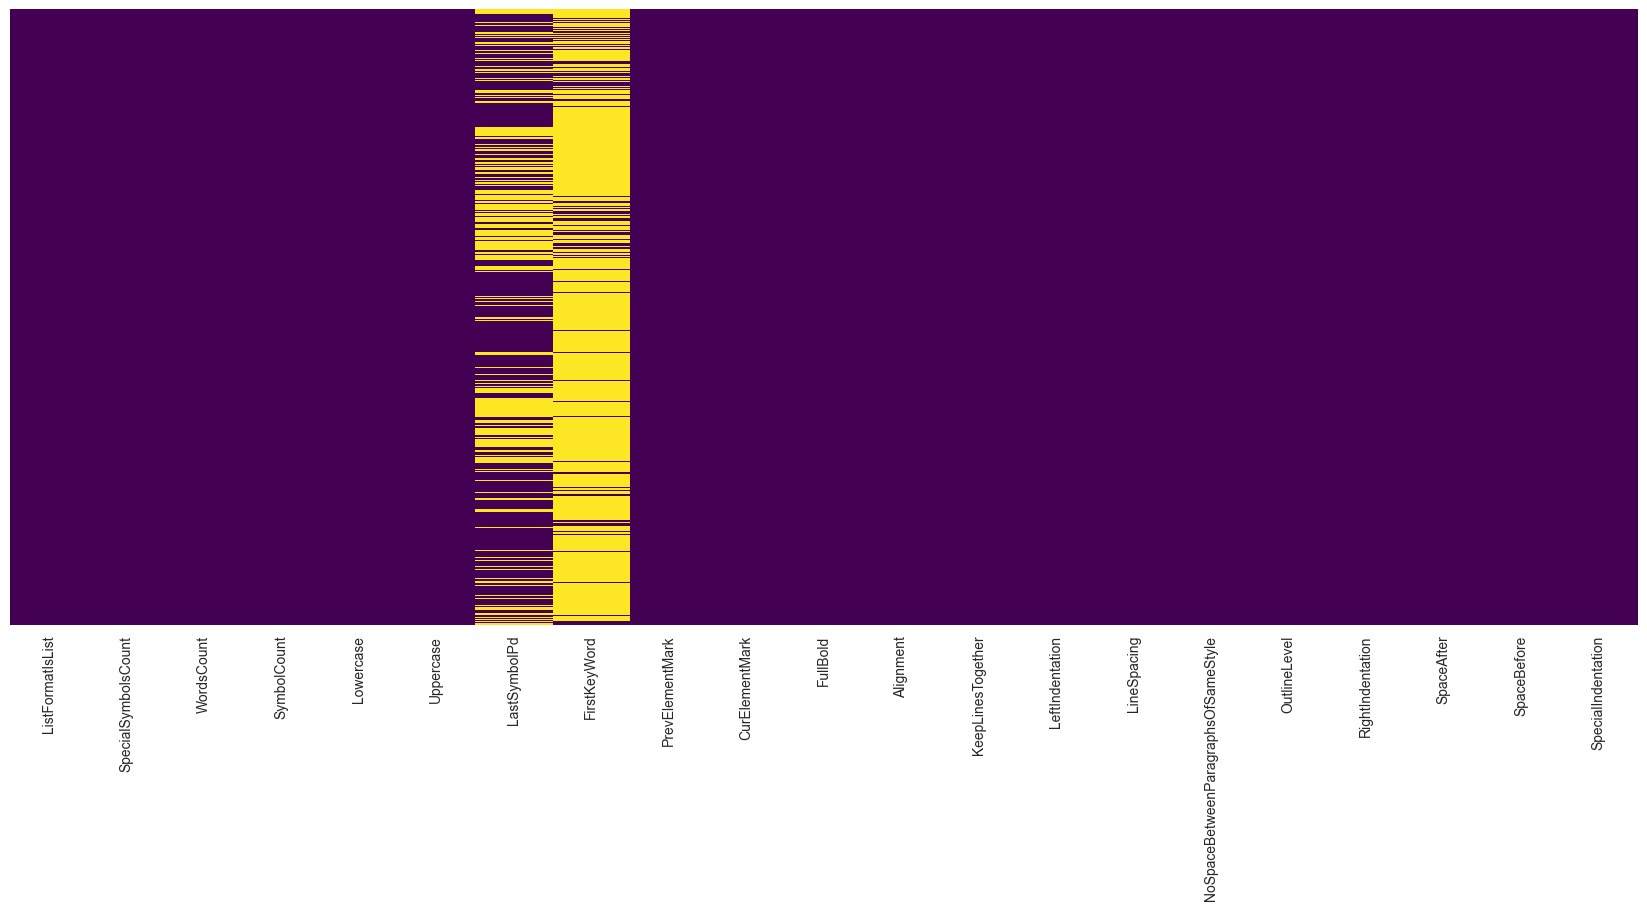

In [287]:
plt.figure(figsize=(21,8))
sns.set_style('whitegrid')
sns.heatmap(df.isnull(), cmap = 'viridis', yticklabels = False, cbar = False)

In [288]:
feature_with_na_values = [feature for feature in df.columns if df[feature].isnull().sum()>1]
for feature in feature_with_na_values:
    print(feature, np.round(df[feature].isnull().mean(),4)*100, '% пропущенных значений')

LastSymbolPd 35.04 % пропущенных значений
FirstKeyWord 85.59 % пропущенных значений


## Общая информаци о датасете

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3379 entries, 0 to 3378
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ListFormatIsList                     3379 non-null   bool   
 1   SpecialSymbolsCount                  3379 non-null   int64  
 2   WordsCount                           3379 non-null   int64  
 3   SymbolCount                          3379 non-null   int64  
 4   Lowercase                            3379 non-null   bool   
 5   Uppercase                            3379 non-null   bool   
 6   LastSymbolPd                         2195 non-null   object 
 7   FirstKeyWord                         487 non-null    object 
 8   PrevElementMark                      3379 non-null   object 
 9   CurElementMark                       3379 non-null   object 
 10  FullBold                             3379 non-null   bool   
 11  Alignment                     

Количество категориальных и числовых признаков

In [290]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
len(categorical_features)

11

In [291]:
numerical_features = [feature for feature in df.columns if feature not in categorical_features]
len(numerical_features)

10

In [292]:
df.describe()

,SpecialSymbolsCount,WordsCount,SymbolCount,SpaceAfter
count,3379.000000,3379.000000,3379.000000,3379.000000
mean,3.073394,27.097366,211.036105,1.076975
std,2.177975,31.335580,241.703817,2.959726
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,6.000000,48.000000,0.000000
50%,3.000000,15.000000,126.000000,0.000000
75%,5.000000,38.000000,299.000000,0.000000
max,12.000000,355.000000,2787.000000,14.000000


## Предобработка и словари

Перечень полей типа 'object'

In [293]:
objectType = list(df.select_dtypes(['object']).columns)
objectType

['LastSymbolPd',
 'FirstKeyWord',
 'PrevElementMark',
 'CurElementMark',
 'Alignment',
 'LeftIndentation',
 'LineSpacing',
 'OutlineLevel',
 'RightIndentation',
 'SpaceBefore',
 'SpecialIndentation']

Перечень полей типа 'bool'

In [294]:
boolType = list(df.select_dtypes(['bool']).columns)
boolType

['ListFormatIsList',
 'Lowercase',
 'Uppercase',
 'FullBold',
 'KeepLinesTogether',
 'NoSpaceBetweenParagraphsOfSameStyle']

### Словари для true и false

Препроцессинг данных. Все объеденено в одну фцнкцию.

Фукция возвразает набор словарей.

Для обращения к словарю, можно обратиться к переменной mappings["Alignment"].

В дальнейшем, для всех тестовых данных должны использоваться именно эти словари.

+ Для булевых полей ставим 0 и 1
+ LastSymbolPd по словарю {np.nan: 4, "." :0, ":" : 1 , ";" : 2, "," : 4}

In [295]:
mappings = {}
def preprocess(df,boolType,objectType):
    le = LabelEncoder()
    for i in boolType:
        df[i] = df[i].astype(int)
    for i in objectType:
        df[i] = df[i].fillna('0')
        le.fit(df[i])
        df[i] = le.transform(df[i])
        mappings[i] = dict(zip(le.classes_, le.transform(le.classes_)))
    return mappings

In [296]:
mappings

{}

In [297]:
df["FirstKeyWord"].unique()

array([nan, 'TitleLevel1', 'listLevel1', 'TitleLevel3', 'TitleLevel2',
       'Таблица', 'Рисунок'], dtype=object)

In [298]:
mappings = preprocess(df,boolType,objectType);

**Пример использования словарей** 

=======================================================================================================================

In [299]:
mapAlignment = mappings["Alignment"]
mapAlignment

{'Center': 0, 'Justify': 1, 'Left': 2, 'Right': 3}

In [300]:
df["Alignment"]

0       2
1       2
2       3
3       0
4       0
       ..
3374    2
3375    3
3376    2
3377    2
3378    2
Name: Alignment, Length: 3379, dtype: int32

In [301]:
df["Alignment"].unique()

array([2, 3, 0, 1])

In [302]:
mapAlignment = {v:k for k, v in mapAlignment.items()} # меняем местами ключ-значение
mapAlignment
df["Alignment"].map(mapAlignment)

0         Left
1         Left
2        Right
3       Center
4       Center
         ...  
3374      Left
3375     Right
3376      Left
3377      Left
3378      Left
Name: Alignment, Length: 3379, dtype: object

=======================================================================================================================

In [303]:
df

,ListFormatIsList,SpecialSymbolsCount,WordsCount,SymbolCount,Lowercase,Uppercase,LastSymbolPd,FirstKeyWord,PrevElementMark,CurElementMark,...,Alignment,KeepLinesTogether,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation
0,0,1,3,47,1,0,2,0,4,3,...,2,0,86,15,0,0,0,0.0,80,29
1,0,2,7,60,0,0,2,0,4,3,...,2,0,86,15,0,0,0,0.0,72,29
2,0,0,3,18,0,0,2,0,29,8,...,3,0,3,15,0,0,91,0.0,0,29
3,0,0,3,27,0,0,2,0,29,3,...,0,0,3,15,0,0,28,0.0,7,29
4,0,1,7,75,0,0,2,0,4,3,...,0,0,133,41,0,0,103,0.0,72,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,0,1,14,103,0,0,2,6,29,15,...,2,0,132,42,0,0,0,0.0,0,1
3375,0,0,2,12,0,0,2,0,29,8,...,3,0,100,15,0,0,0,0.1,97,29
3376,0,1,6,39,0,0,2,6,29,15,...,2,0,100,68,0,0,23,0.0,0,29
3377,0,0,1,0,1,1,2,0,20,16,...,2,0,3,68,0,0,23,0.0,0,29


# Обучение модели CatBoost

In [304]:
#y = df["CurElementMark"].to_numpy()
#X = df.drop("CurElementMark", axis = 1).to_numpy() 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y = df["CurElementMark"]
X = df.drop("CurElementMark", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [358]:
model = CatBoostClassifier(iterations=1000 , task_type="CPU",depth= 4, l2_leaf_reg=3, learning_rate=0.11)

In [359]:
cat = model.fit(X_train, y_train)

0:	learn: 2.1991402	total: 6.99ms	remaining: 6.98s
1:	learn: 1.9144785	total: 14ms	remaining: 6.97s
2:	learn: 1.7090449	total: 20.7ms	remaining: 6.89s
3:	learn: 1.5640898	total: 27.1ms	remaining: 6.75s
4:	learn: 1.4553544	total: 33.4ms	remaining: 6.65s
5:	learn: 1.3700007	total: 39.3ms	remaining: 6.52s
6:	learn: 1.2729470	total: 45ms	remaining: 6.39s
7:	learn: 1.1961997	total: 50.9ms	remaining: 6.32s
8:	learn: 1.1210131	total: 56.4ms	remaining: 6.21s
9:	learn: 1.0612121	total: 62ms	remaining: 6.14s
10:	learn: 1.0192581	total: 67.4ms	remaining: 6.06s
11:	learn: 0.9669598	total: 72.9ms	remaining: 6s
12:	learn: 0.9237918	total: 78.6ms	remaining: 5.97s
13:	learn: 0.8878677	total: 84.5ms	remaining: 5.95s
14:	learn: 0.8595452	total: 90ms	remaining: 5.91s
15:	learn: 0.8311966	total: 95.5ms	remaining: 5.87s
16:	learn: 0.8063675	total: 101ms	remaining: 5.82s
17:	learn: 0.7854326	total: 107ms	remaining: 5.81s
18:	learn: 0.7629023	total: 113ms	remaining: 5.82s
19:	learn: 0.7472771	total: 118ms	re

185:	learn: 0.2261002	total: 1.04s	remaining: 4.56s
186:	learn: 0.2257287	total: 1.05s	remaining: 4.55s
187:	learn: 0.2252448	total: 1.05s	remaining: 4.55s
188:	learn: 0.2245878	total: 1.06s	remaining: 4.56s
189:	learn: 0.2238802	total: 1.08s	remaining: 4.59s
190:	learn: 0.2229221	total: 1.08s	remaining: 4.59s
191:	learn: 0.2222264	total: 1.09s	remaining: 4.58s
192:	learn: 0.2217097	total: 1.09s	remaining: 4.58s
193:	learn: 0.2211260	total: 1.1s	remaining: 4.57s
194:	learn: 0.2204700	total: 1.11s	remaining: 4.57s
195:	learn: 0.2200910	total: 1.11s	remaining: 4.57s
196:	learn: 0.2191705	total: 1.12s	remaining: 4.57s
197:	learn: 0.2186274	total: 1.13s	remaining: 4.56s
198:	learn: 0.2178059	total: 1.13s	remaining: 4.55s
199:	learn: 0.2172662	total: 1.14s	remaining: 4.55s
200:	learn: 0.2164877	total: 1.14s	remaining: 4.54s
201:	learn: 0.2161012	total: 1.15s	remaining: 4.54s
202:	learn: 0.2157812	total: 1.15s	remaining: 4.53s
203:	learn: 0.2153693	total: 1.16s	remaining: 4.52s
204:	learn: 0

362:	learn: 0.1565537	total: 2.06s	remaining: 3.62s
363:	learn: 0.1563689	total: 2.07s	remaining: 3.61s
364:	learn: 0.1562618	total: 2.07s	remaining: 3.61s
365:	learn: 0.1558516	total: 2.08s	remaining: 3.6s
366:	learn: 0.1556663	total: 2.08s	remaining: 3.59s
367:	learn: 0.1555045	total: 2.09s	remaining: 3.59s
368:	learn: 0.1549644	total: 2.09s	remaining: 3.58s
369:	learn: 0.1547012	total: 2.1s	remaining: 3.58s
370:	learn: 0.1546353	total: 2.1s	remaining: 3.57s
371:	learn: 0.1544656	total: 2.11s	remaining: 3.56s
372:	learn: 0.1540307	total: 2.12s	remaining: 3.56s
373:	learn: 0.1538414	total: 2.12s	remaining: 3.55s
374:	learn: 0.1535726	total: 2.13s	remaining: 3.54s
375:	learn: 0.1533459	total: 2.13s	remaining: 3.54s
376:	learn: 0.1530456	total: 2.14s	remaining: 3.53s
377:	learn: 0.1526523	total: 2.14s	remaining: 3.53s
378:	learn: 0.1524037	total: 2.15s	remaining: 3.52s
379:	learn: 0.1522242	total: 2.15s	remaining: 3.51s
380:	learn: 0.1519738	total: 2.16s	remaining: 3.51s
381:	learn: 0.1

523:	learn: 0.1211055	total: 3.08s	remaining: 2.8s
524:	learn: 0.1208614	total: 3.09s	remaining: 2.79s
525:	learn: 0.1207613	total: 3.1s	remaining: 2.79s
526:	learn: 0.1203916	total: 3.1s	remaining: 2.79s
527:	learn: 0.1201368	total: 3.11s	remaining: 2.78s
528:	learn: 0.1197297	total: 3.12s	remaining: 2.78s
529:	learn: 0.1196262	total: 3.13s	remaining: 2.77s
530:	learn: 0.1193440	total: 3.13s	remaining: 2.77s
531:	learn: 0.1190562	total: 3.14s	remaining: 2.76s
532:	learn: 0.1187318	total: 3.15s	remaining: 2.76s
533:	learn: 0.1185438	total: 3.16s	remaining: 2.75s
534:	learn: 0.1184004	total: 3.17s	remaining: 2.75s
535:	learn: 0.1180326	total: 3.18s	remaining: 2.75s
536:	learn: 0.1179719	total: 3.18s	remaining: 2.75s
537:	learn: 0.1176871	total: 3.19s	remaining: 2.74s
538:	learn: 0.1176096	total: 3.2s	remaining: 2.74s
539:	learn: 0.1174651	total: 3.21s	remaining: 2.73s
540:	learn: 0.1173264	total: 3.22s	remaining: 2.73s
541:	learn: 0.1170475	total: 3.23s	remaining: 2.73s
542:	learn: 0.11

694:	learn: 0.0946776	total: 4.32s	remaining: 1.9s
695:	learn: 0.0945768	total: 4.33s	remaining: 1.89s
696:	learn: 0.0944481	total: 4.35s	remaining: 1.89s
697:	learn: 0.0943571	total: 4.37s	remaining: 1.89s
698:	learn: 0.0942401	total: 4.38s	remaining: 1.89s
699:	learn: 0.0941071	total: 4.39s	remaining: 1.88s
700:	learn: 0.0938909	total: 4.4s	remaining: 1.88s
701:	learn: 0.0938254	total: 4.42s	remaining: 1.88s
702:	learn: 0.0935754	total: 4.43s	remaining: 1.87s
703:	learn: 0.0935035	total: 4.44s	remaining: 1.87s
704:	learn: 0.0934402	total: 4.45s	remaining: 1.86s
705:	learn: 0.0932461	total: 4.45s	remaining: 1.85s
706:	learn: 0.0930536	total: 4.46s	remaining: 1.85s
707:	learn: 0.0928877	total: 4.47s	remaining: 1.84s
708:	learn: 0.0926739	total: 4.48s	remaining: 1.84s
709:	learn: 0.0925225	total: 4.49s	remaining: 1.83s
710:	learn: 0.0924431	total: 4.5s	remaining: 1.83s
711:	learn: 0.0923733	total: 4.51s	remaining: 1.82s
712:	learn: 0.0923181	total: 4.52s	remaining: 1.82s
713:	learn: 0.0

865:	learn: 0.0766532	total: 5.54s	remaining: 858ms
866:	learn: 0.0766272	total: 5.55s	remaining: 852ms
867:	learn: 0.0765903	total: 5.56s	remaining: 845ms
868:	learn: 0.0765140	total: 5.56s	remaining: 839ms
869:	learn: 0.0763270	total: 5.57s	remaining: 832ms
870:	learn: 0.0762647	total: 5.58s	remaining: 826ms
871:	learn: 0.0761182	total: 5.58s	remaining: 819ms
872:	learn: 0.0760513	total: 5.59s	remaining: 813ms
873:	learn: 0.0759107	total: 5.59s	remaining: 806ms
874:	learn: 0.0758605	total: 5.6s	remaining: 800ms
875:	learn: 0.0757754	total: 5.61s	remaining: 793ms
876:	learn: 0.0757180	total: 5.61s	remaining: 787ms
877:	learn: 0.0756150	total: 5.62s	remaining: 780ms
878:	learn: 0.0754898	total: 5.62s	remaining: 774ms
879:	learn: 0.0754248	total: 5.63s	remaining: 767ms
880:	learn: 0.0753601	total: 5.63s	remaining: 761ms
881:	learn: 0.0752427	total: 5.64s	remaining: 755ms
882:	learn: 0.0751024	total: 5.65s	remaining: 748ms
883:	learn: 0.0749470	total: 5.65s	remaining: 742ms
884:	learn: 0

In [360]:
model.score(X_test, y_test)

0.9260355029585798

In [308]:
y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred, target_names=target_names))
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.71      0.71      0.71         7
           2       1.00      0.67      0.80         3
           3       1.00      0.83      0.91        12
           4       0.50      0.67      0.57         6
           5       0.60      0.50      0.55         6
           6       1.00      1.00      1.00         3
           7       1.00      0.60      0.75         5
           8       0.97      0.97      0.97       332
           9       0.74      1.00      0.85        17
          10       0.73      0.89      0.80         9
          11       0.85      0.86      0.86        80
          12       0.74      0.61      0.67        23
          13       0.75      0.60      0.67         5
          14       0.93      0.87      0.90        15
          15       0.75      1.00      0.86         3
          16       1.00      0.97      0.98        29
          17       0.88    

## Экпорт модели

In [309]:
import joblib

In [310]:
# joblib.dump(model, "model-next.pkl")
joblib.dump(model, "scopus.pkl")

['scopus.pkl']

In [311]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,PrevElementMark,18.604781
1,SpecialIndentation,11.558044
2,FirstKeyWord,9.307010
3,LeftIndentation,8.339393
4,LastSymbolPd,8.155454
5,SymbolCount,7.765535
6,ListFormatIsList,6.546469
7,LineSpacing,4.357845
8,WordsCount,4.313485
9,Lowercase,3.836715


In [312]:
res = model.get_feature_importance()

In [313]:
res

array([6.54646900e+00, 3.83233812e+00, 4.31348495e+00, 7.76553513e+00,
       3.83671454e+00, 3.10824743e+00, 8.15545355e+00, 9.30700950e+00,
       1.86047813e+01, 1.80680525e+00, 3.34909198e+00, 9.89759490e-03,
       8.33939263e+00, 4.35784482e+00, 1.35719409e+00, 3.58044693e-01,
       7.61671131e-01, 9.19175106e-01, 1.71280543e+00, 1.15580438e+01])

In [314]:
u = df.drop("CurElementMark", axis = 1).columns

<AxesSubplot:>

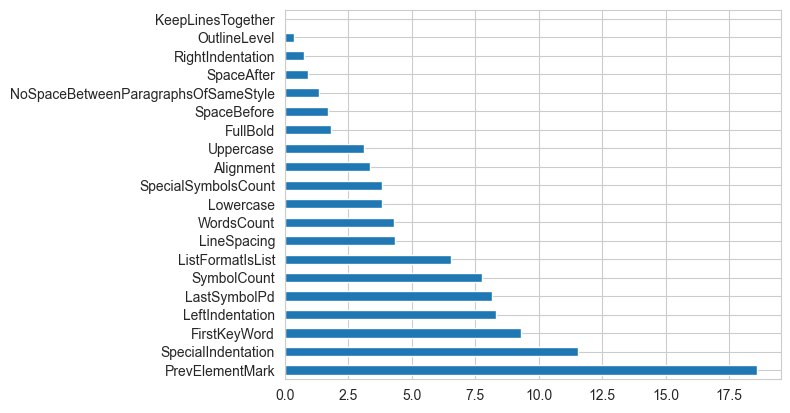

In [315]:
%matplotlib inline  
(pd.Series(res, index=u)
   .nlargest(100)
  .plot(kind='barh')
)

# Проверка модели на для NEXT

RightIndentation превращаем в object, так как по-умолчанию это int64

Надо либо в исходном датасете преобразовать в int либо тут в object

TODO Преобразовать в первом датасете в int

In [ ]:
pd.options.display.max_rows = 999

In [201]:
test= pd.read_csv(r"C:\Users\KK\Downloads\main_dataset6_thr12.csv", skipinitialspace=True, sep=",", dtype={'RightIndentation': object, "SpaceAfter" : object})
#test= pd.read_csv("scopus_test.csv", skipinitialspace=True, dtype={'RightIndentation': object, "SpaceAfter" : object})

In [202]:
#testNext = test.drop("PrevElementMark", axis = 1)
#test = test.drop("Content", axis = 1)
#testNext

In [203]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3380 entries, 0 to 3379
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   ListFormatIsList                     3380 non-null   bool  
 1   SpecialSymbolsCount                  3380 non-null   int64 
 2   WordsCount                           3380 non-null   int64 
 3   SymbolCount                          3380 non-null   int64 
 4   Lowercase                            3380 non-null   bool  
 5   Uppercase                            3380 non-null   bool  
 6   LastSymbolPd                         2195 non-null   object
 7   FirstKeyWord                         487 non-null    object
 8   PrevElementMark                      3380 non-null   object
 9   CurElementMark                       3380 non-null   object
 10  NextElementMark                      3380 non-null   object
 11  FullBold                             3380 n

In [204]:
test_predict_original = test["CurElementMark"]

In [205]:
objectTypeTest = list(test.select_dtypes(['object']).columns)
objectTypeTest

['LastSymbolPd',
 'FirstKeyWord',
 'PrevElementMark',
 'CurElementMark',
 'NextElementMark',
 'Alignment',
 'LeftIndentation',
 'LineSpacing',
 'OutlineLevel',
 'RightIndentation',
 'SpaceAfter',
 'SpaceBefore',
 'SpecialIndentation']

In [206]:
boolTypeTest = list(test.select_dtypes(['bool']).columns)
boolType

['ListFormatIsList',
 'Lowercase',
 'Uppercase',
 'FullBold',
 'FullItalic',
 'NoSpaceBetweenParagraphsOfSameStyle']

In [207]:
def preprocess_test(test, mappings,boolTypeTest,objectTypeTest):
    for i in boolTypeTest:
        test[i] = test[i].map(int)
    for i in objectTypeTest:
        test[i] = test[i].fillna('0')
        mapForItem = mappings[i]
        test[i] =  test[i].map(mapForItem)
    return test

In [208]:
dataTestNext = preprocess_test(test, mappings,boolTypeTest,objectTypeTest )

KeyError: 'SpaceAfter'

In [195]:
model = joblib.load("scopus.pkl")

In [196]:
TestNext_pred= model.predict(dataTestNext, prediction_type="Class")

NameError: name 'dataTestNext' is not defined

In [ ]:
testNext_predict_original = pd.DataFrame(TestNext_pred)
testNext_predict_original

In [ ]:
testNext_predict_original['predict'] = TestNext_pred
testNext_predict_original

In [49]:
mapCurElementMark = {v:k for k, v in mappings["CurElementMark"].items()} # меняем местами ключ-значение
mapCurElementMark
testNext_predict_original['predict'] = testNext_predict_original['predict'].map(mapCurElementMark)

KeyError: 'CurElementMark'

In [50]:
testNext_predict_original

,0,predict
0,1,1
1,7,7
2,1,1
3,6,6
4,7,7
5,4,4
6,5,5
7,0,0
8,2,2


In [52]:
testNext_predict_original.to_csv("scopus-predict_tmp.csv",index=True, header = True, sep=",")

In [53]:
def inverse_test(test, mappings):
    for i in boolTypeTest:
        test[i] = test[i].map({1:"True", 0: "False"})
    for i in objectTypeTest:
        mapForItem = {v:k for k, v in mappings[i].items()}
        test[i] =  test[i].map(mapForItem)
    return test

In [54]:
testNext = inverse_test(test, mappings)
testNext

,SymbolCount,WordsCount,SpecialSymbolsCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,FullBold,FullItalic,Alignment,...,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation,FirstKeyWord_missed,LastSymbolPd_missed,CurElementMark
0,163.0,19.0,4,False,False,.,Рисунок,False,False,Justify,...,False,BodyText,False,0,0,0.0,-35.45,True,False,NaN
1,31.0,5.0,1,False,False,.,Таблица,False,False,Justify,...,False,BodyText,False,0.0,0.0,0.0,0.00,False,True,NaN
2,342.0,34.0,7,False,False,.,Рисунок,False,False,Justify,...,False,BodyText,False,0,0,0.0,-36.00,True,False,NaN
3,20.0,3.0,1,False,False,.,TitleLevel3,True,False,Left,...,False,Level2,False,0.0,0.0,0.0,0.00,False,True,NaN
4,81.0,9.0,1,False,False,.,Таблица,False,False,Justify,...,False,BodyText,False,0,0,0.0,0.00,False,True,NaN
5,64.0,8.0,1,False,False,.,TitleLevel2,True,False,Left,...,False,Level2,False,0,0,10.0,0.00,False,True,NaN
6,49.0,7.0,1,False,False,.,Рисунок,False,False,Center,...,True,BodyText,False,0,0,0.0,0.00,False,True,NaN
7,32.0,3.0,0,True,False,.,Рисунок,True,False,Center,...,False,Level1,False,0.0,6.0,24.0,0.00,True,True,NaN
8,71.0,8.0,1,False,False,:,Рисунок,False,False,Justify,...,False,BodyText,False,0,0,0.0,-35.40,True,False,NaN


In [55]:
testNext['predict'] = TestNext_pred
testNext['predict'] = testNext['predict'].map(mapCurElementMark)

NameError: name 'mapCurElementMark' is not defined

In [56]:
test.to_csv("minipredict-012023-main.csv",index=True, header = True, sep=";")

# Проверка модели на для PREV

In [57]:
test= pd.read_csv("test_libre-cool-prev.csv", skipinitialspace=True, sep=";", dtype={'RightIndentation': object, "SpaceAfter" : object})

FileNotFoundError: [Errno 2] File b'test_libre-cool-prev.csv' does not exist: b'test_libre-cool-prev.csv'

In [3]:
test.columns

Index(['Content', 'SpecialSymbolsCount', 'WordsCount', 'SymbolCount',
       'lowercase', 'uppercase', 'LastSymbolPd', 'FirstKeyWord',
       'CurElementMark', 'NextElementMark', 'FullBold', 'FullItalic',
       'Alignment', 'KeepLinesTogether', 'KeepWithNext', 'LeftIndentation',
       'LineSpacing', 'NoSpaceBetweenParagraphsOfSameStyle', 'OutlineLevel',
       'PageBreakBefore', 'RightIndentation', 'SpaceAfter', 'SpaceBefore',
       'SpecialIndentation'],
      dtype='object')

In [4]:
testPrev_predict_original = test["CurElementMark"]

In [5]:
testPrev = test.drop(["NextElementMark","Content"], axis = 1)
#testPrev = testPrev.drop([], axis = 1)
#testPrev

In [6]:
testPrev.columns

Index(['SpecialSymbolsCount', 'WordsCount', 'SymbolCount', 'lowercase',
       'uppercase', 'LastSymbolPd', 'FirstKeyWord', 'CurElementMark',
       'FullBold', 'FullItalic', 'Alignment', 'KeepLinesTogether',
       'KeepWithNext', 'LeftIndentation', 'LineSpacing',
       'NoSpaceBetweenParagraphsOfSameStyle', 'OutlineLevel',
       'PageBreakBefore', 'RightIndentation', 'SpaceAfter', 'SpaceBefore',
       'SpecialIndentation'],
      dtype='object')

In [7]:
testPrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 22 columns):
SpecialSymbolsCount                    210 non-null int64
WordsCount                             210 non-null int64
SymbolCount                            210 non-null int64
lowercase                              210 non-null bool
uppercase                              210 non-null bool
LastSymbolPd                           145 non-null object
FirstKeyWord                           103 non-null object
CurElementMark                         210 non-null object
FullBold                               210 non-null bool
FullItalic                             210 non-null bool
Alignment                              210 non-null object
KeepLinesTogether                      210 non-null bool
KeepWithNext                           210 non-null bool
LeftIndentation                        210 non-null object
LineSpacing                            210 non-null object
NoSpaceBetweenParagraphsO

In [8]:
objectTypeTest = list(testPrev.select_dtypes(['object']).columns)
objectTypeTest 

['LastSymbolPd',
 'FirstKeyWord',
 'CurElementMark',
 'Alignment',
 'LeftIndentation',
 'LineSpacing',
 'OutlineLevel',
 'RightIndentation',
 'SpaceAfter',
 'SpecialIndentation']

In [9]:
boolTypeTest = list(testPrev.select_dtypes(['bool']).columns)
boolTypeTest

['lowercase',
 'uppercase',
 'FullBold',
 'FullItalic',
 'KeepLinesTogether',
 'KeepWithNext',
 'NoSpaceBetweenParagraphsOfSameStyle',
 'PageBreakBefore']

In [10]:
testPrev.columns

Index(['SpecialSymbolsCount', 'WordsCount', 'SymbolCount', 'lowercase',
       'uppercase', 'LastSymbolPd', 'FirstKeyWord', 'CurElementMark',
       'FullBold', 'FullItalic', 'Alignment', 'KeepLinesTogether',
       'KeepWithNext', 'LeftIndentation', 'LineSpacing',
       'NoSpaceBetweenParagraphsOfSameStyle', 'OutlineLevel',
       'PageBreakBefore', 'RightIndentation', 'SpaceAfter', 'SpaceBefore',
       'SpecialIndentation'],
      dtype='object')

In [11]:
dataTestPrev = preprocess_test(testPrev, mappings,boolTypeTest,objectTypeTest )

NameError: name 'preprocess_test' is not defined

In [ ]:
model = joblib.load("model-prev.pkl")
testPrev_pred= model.predict(dataTestPrev, prediction_type="Class")

In [12]:
testPrev_predict_original = pd.DataFrame(testPrev_predict_original)
testPrev_predict_original

,CurElementMark
0,b1
1,c1
2,c1
3,c2
4,d2
...,...
205,d2
206,d2
207,c1
208,b1


In [13]:
testPrev_predict_original['predict'] = testPrev_pred
testPrev_predict_original

NameError: name 'testPrev_pred' is not defined

In [14]:
mapCurElementMark = {v:k for k, v in mappings["CurElementMark"].items()} # меняем местами ключ-значение
mapCurElementMark
testPrev_predict_original['predict'] = testPrev_predict_original['predict'].map(mapCurElementMark)

NameError: name 'mappings' is not defined

In [15]:
testPrev_predict_original

,CurElementMark
0,b1
1,c1
2,c1
3,c2
4,d2
...,...
205,d2
206,d2
207,c1
208,b1


In [16]:
testPrev_predict_original.to_csv("predict-prev-current+predict.csv",index=True, header = True, sep=";")

In [93]:
def inverse_test(test, mappings):
    for i in boolTypeTest:
        test[i] = test[i].map({1:"True", 0: "False"})
    for i in objectTypeTest:
        mapForItem = {v:k for k, v in mappings[i].items()}
        test[i] =  test[i].map(mapForItem)
    return test

In [94]:
testPrev = inverse_test(testPrev, mappings)
testPrev

,SpecialSymbolsCount,WordsCount,SymbolCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,CurElementMark,FullBold,FullItalic,...,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation
0,0,1,8,False,False,0,TitleLevel1,b1,True,False,...,False,0,"1,5",False,Level1,False,0,0,0,0
1,5,28,271,False,False,.,0,c1,False,False,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
2,8,39,373,False,False,.,0,c1,False,False,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
3,4,19,163,False,False,:,0,c2,False,False,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
4,3,4,41,True,False,;,listLevel1,d2,False,False,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
5,2,5,50,True,False,;,listLevel1,d2,False,False,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
6,3,7,63,True,False,.,listLevel1,d2,False,False,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
7,14,53,492,False,False,.,0,c1,False,False,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
8,12,79,674,False,False,.,0,c1,False,False,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
9,1,11,74,False,False,:,0,c2,False,False,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"


In [95]:
testPrev['predict'] = testPrev_pred
testPrev['predict'] = testPrev['predict'].map(mapCurElementMark)

In [96]:
test.to_csv("predict-prev.csv",index=True, header = True, sep=";")

# Графики

## Корреляционные матрицы

In [176]:
df.corr()

,ListFormatIsList,SpecialSymbolsCount,WordsCount,SymbolCount,Lowercase,Uppercase,LastSymbolPd,FirstKeyWord,PrevElementMark,CurElementMark,...,FullItalic,Alignment,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation
ListFormatIsList,1.000000,0.003950,-0.246085,-0.236194,-0.161637,0.080191,0.280844,-0.168952,0.123937,0.144705,...,-0.045817,0.109150,0.123447,0.080304,0.450041,0.127936,-0.015026,0.052927,-0.043055,0.647191
SpecialSymbolsCount,0.003950,1.000000,0.518479,0.524446,-0.378282,-0.309577,-0.169969,0.020824,0.127283,0.081801,...,-0.064314,-0.071695,0.105698,0.056054,-0.103364,-0.156935,0.320647,-0.046844,0.123345,-0.154708
WordsCount,-0.246085,0.518479,1.000000,0.985736,-0.248501,-0.303025,-0.309430,-0.124975,-0.083102,-0.227999,...,-0.054684,-0.203972,-0.029734,-0.021941,-0.132440,-0.103015,0.255610,0.139490,0.028579,-0.298162
SymbolCount,-0.236194,0.524446,0.985736,1.000000,-0.258918,-0.305283,-0.305827,-0.130905,-0.095616,-0.239300,...,-0.054591,-0.207036,-0.054635,0.003752,-0.122573,-0.100530,0.233045,0.120594,0.019144,-0.299408
Lowercase,-0.161637,-0.378282,-0.248501,-0.258918,1.000000,0.388897,0.067017,-0.030893,0.105359,0.276804,...,-0.014003,0.205047,-0.004801,-0.111661,-0.128718,0.041210,-0.130352,-0.060120,-0.010293,0.034575
Uppercase,0.080191,-0.309577,-0.303025,-0.305283,0.388897,1.000000,0.368046,0.100613,0.053532,0.205129,...,0.007242,0.133562,-0.086014,0.094429,0.132803,-0.054587,-0.146215,-0.068183,-0.091748,0.117790
LastSymbolPd,0.280844,-0.169969,-0.309430,-0.305827,0.067017,0.368046,1.000000,0.197421,-0.019841,0.037016,...,0.024076,0.010056,0.056247,-0.017389,0.137764,0.039242,-0.038102,-0.043920,-0.028906,0.246500
FirstKeyWord,-0.168952,0.020824,-0.124975,-0.130905,-0.030893,0.100613,0.197421,1.000000,0.026890,0.257874,...,-0.027267,-0.031039,0.005150,0.041703,-0.090736,-0.038794,-0.075642,-0.106702,-0.009176,-0.082401
PrevElementMark,0.123937,0.127283,-0.083102,-0.095616,0.105359,0.053532,-0.019841,0.026890,1.000000,0.512290,...,-0.023379,0.171675,0.288736,0.015469,0.042633,-0.071569,0.107060,-0.117979,0.148286,0.103726
CurElementMark,0.144705,0.081801,-0.227999,-0.239300,0.276804,0.205129,0.037016,0.257874,0.512290,1.000000,...,-0.056677,0.386194,0.274567,-0.047032,0.072048,-0.173877,-0.065939,-0.099680,0.102993,0.180219


<AxesSubplot:>

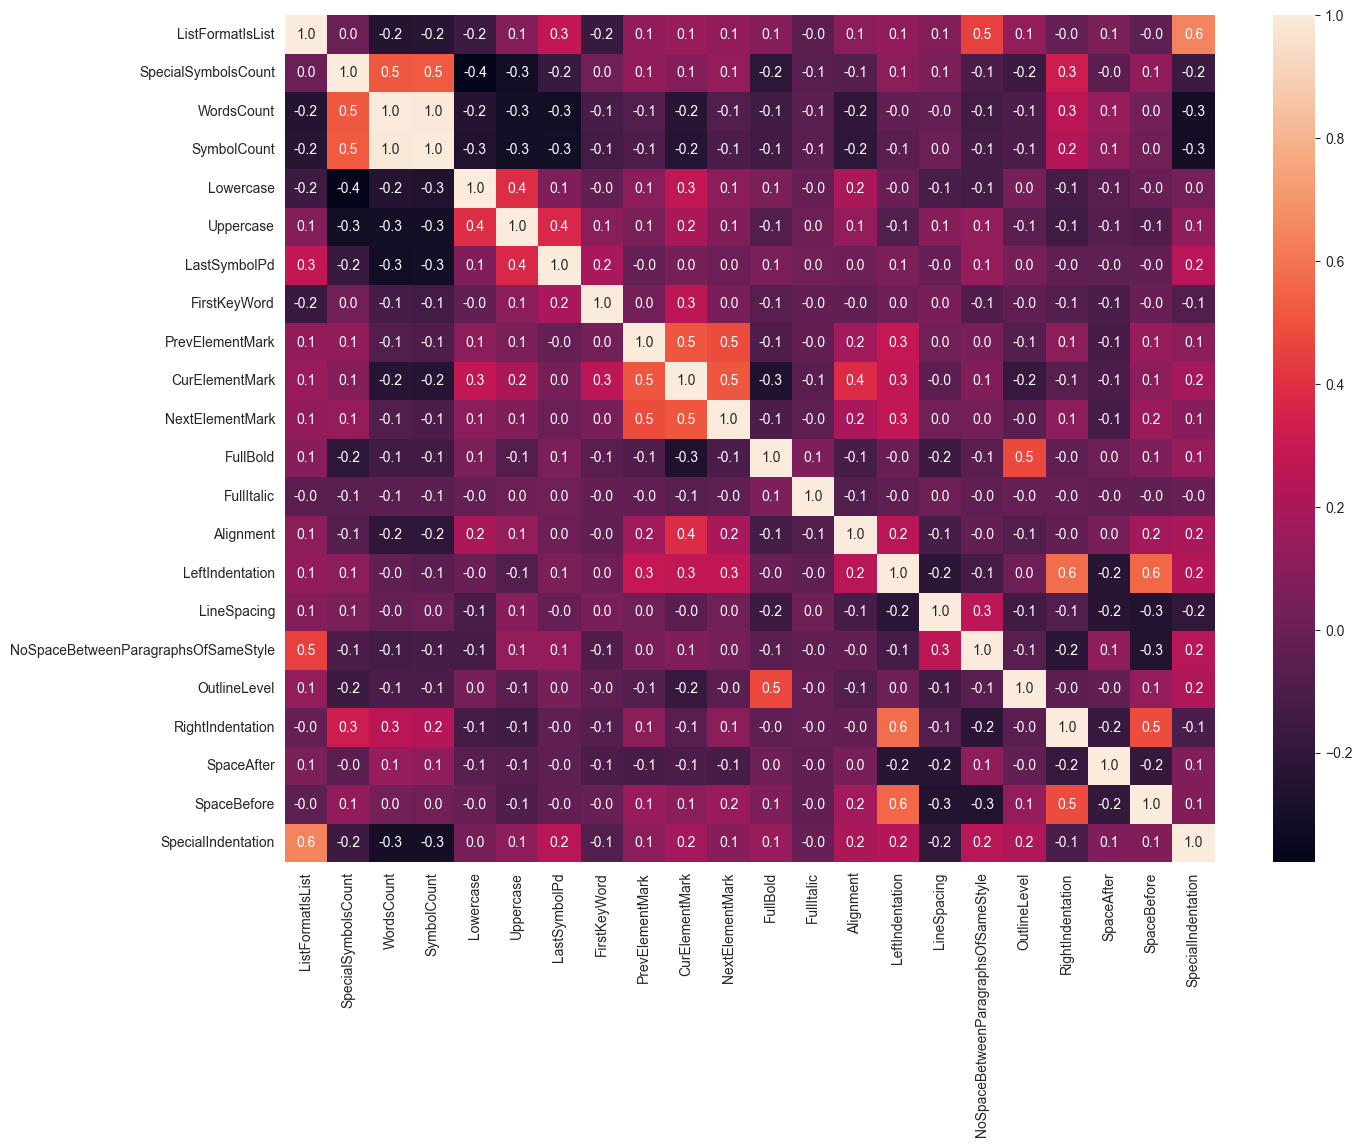

In [177]:
plt.figure(figsize = (15,11))
sns.heatmap(df.corr(), annot = True, fmt = ".1f")

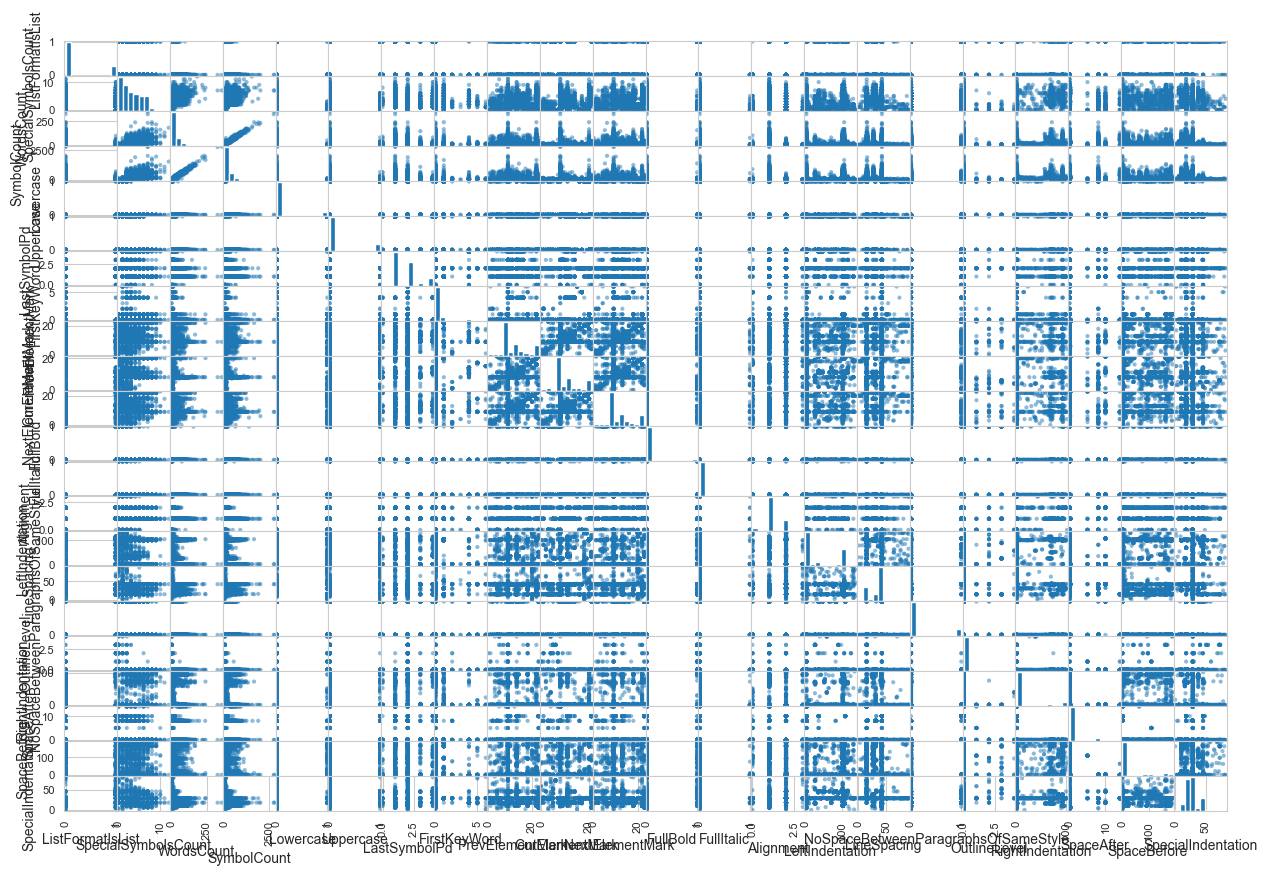

In [178]:
pd.plotting.scatter_matrix(df, figsize = (15,10));

In [179]:
from pandas_profiling import ProfileReport

ModuleNotFoundError: No module named 'pandas_profiling'

In [ ]:
profile = ProfileReport(df)

In [ ]:
profile.to_file("Отчет по датасету-prev.html")

In [ ]:
profile